# Round-off errors

When you use `x = 1/49` to compute the reciprocal of 49, you get the fraction 1/49. But if you print `x`, you might be surprised to see

```julia
julia> x = 1/49
0.02040816326530612
```

and then go on to compute `x * 49` and get

```julia
julia> x * 49
0.9999999999999999
```

and not 1.0. What is going on?

The problem is that floating-point numbers are represented with a fixed number of bits, and there are many numbers that cannot be represented exactly with a fixed number of bits. When you write `1/49`, Julia converts the integer 1 to the floating-point representation with 64 bits, and the integer 49 to the floating-point representation with 64 bits, and then divides the two floating-point numbers. The result is very close to 1/49, but not exact.

When you multiply `x` by 49, you get a number that is very close to 1, but not exact, so when you print it, you get `0.9999999999999999`.

What is error of precision? It is the difference between the result you get from a floating-point operation and the result you would get if you could compute the operation with real numbers.

In this example, the error of precision is about `1e-16`, which is the difference between 1 and the floating-point representation of 1.0.


In [1]:
x = 1/49

0.02040816326530612

In [2]:
x * 49

0.9999999999999999

In [3]:
1 - x * 49

1.1102230246251565e-16

## Accumulated Error Function

The following function computes the accumulated error of a sequence of floating-point numbers:

- The function `accumulated_error` takes a sequence of floating-point numbers and computes the accumulated error of the sum.
- Inside the function
    - `y = similar(x)` creates a new array with the same type and shape as `x`.
    - `y[1] = x[1]` copies the first element of `x` to the first element of `y`.
    - The `for` loop starts at the second element and adds up the differences between successive elements of `x`.
    - The result is an array that contains the accumulated error of the sum of `x`.

In [4]:
function accumulated_error(x)
    y = similar(x)
    y[1] = x[1]
    for i in 2:length(x)
        y[i] = y[i-1] + x[i]
    end

    return y
end

accumulated_error (generic function with 1 method)

In [5]:
input_array = [1, 2, 3, 4, 5]

result_array = accumulated_error(input_array)

println("Input array: $input_array")
println("Accumulated sum array: $result_array")

Input array: [1, 2, 3, 4, 5]
Accumulated sum array: [1, 3, 6, 10, 15]


In [6]:
eps(Float32), eps(Float64)

(1.1920929f-7, 2.220446049250313e-16)

## Accumulated Error Analysis with Single Precision

This Julia code utilizes PyPlot for visualization and defines a function `plot_error_analysis()` to analyze the accumulated error in summing 10^7 random single precision values. Here's a step-by-step explanation:

1. **Data Generation**: Generates an array `x` containing 10^7 single precision (Float32) random values uniformly distributed between 0 and 1.

2. **Accumulated Error Calculation**:

   - `@time y = accumulated_error(x)`: Measures the time and computes the accumulated error using a function called `accumulated_error()` (not shown here).

   - `y_exact = accumulated_error(Float64.(x))`: Converts `x` to double precision (Float64) to obtain a more accurate comparison for the accumulated error.

   - `err = abs.(y .- y_exact ./ abs.(y_exact))`: Computes the relative error between the single and double precision accumulations.

3. **Plotting**:

   - Defines `n` to plot every 10th point in the `err` array.

   - `loglog(n, err[n])`: Plots the log-log of the error against the number of summands.

   - Adds axis labels (`ylabel`, `xlabel`) and a title (`title`) for clarity in the plot.

4. **Comparison Line**:

   - `loglog([1, length(err)], sqrt.([1, length(err)]) * 1e-7, "k--")`: Plots a line proportional to √n for comparison.

5. **Text Annotation**:

   - `text(1e3, 1e-5, L"\sim \sqrt{n}", fontsize=16)`: Adds a text annotation displaying the square root relationship at a specified position on the plot.

6. **Execution**:
   - `plot_error_analysis()`: Calls the function to execute the code and display the plot.

This code aims to visualize and analyze the error that arises from summing a large number of single precision random values compared to their double precision counterparts.


  0.120359 seconds (2 allocations: 381.470 MiB, 1.81% gc time)


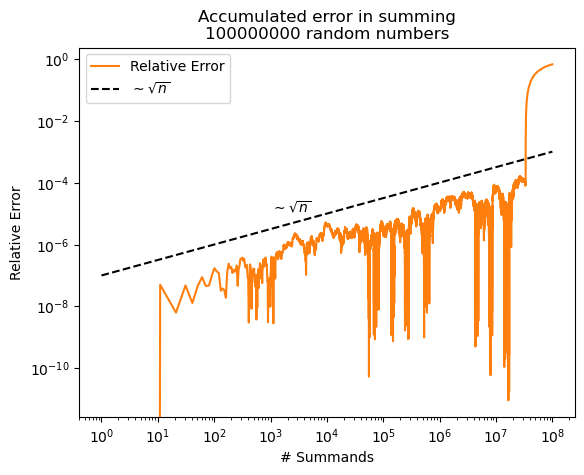

PyObject <matplotlib.legend.Legend object at 0x7f24aaeaf910>

In [7]:
using PyPlot

function plot_error_analysis(size_rand_array::Int = 10^8)
    x = rand(Float32, size_rand_array)
    @time y = accumulated_error(x)
    y_exact = accumulated_error(Float64.(x))
    err = abs.(y .- y_exact) ./ abs.(y_exact) # take absolute value of summed array minus exact array, divide by exact array

    n = 1:10:length(err)
    loglog(n, err[n], color="C1", label="Relative Error")
    ylabel("Relative Error")
    xlabel("# Summands")

    loglog([1, length(err)], sqrt.([1, length(err)]) * 1e-7, "k--", label=L"\sim \sqrt{n}")
    text(1e3, 1e-5, L"\sim \sqrt{n}", transform=gca().transData)
    title("Accumulated error in summing" * "\n" * "$size_rand_array random numbers")

    legend()
end

plot_error_analysis()

  0.492972 seconds (2 allocations: 381.470 MiB)


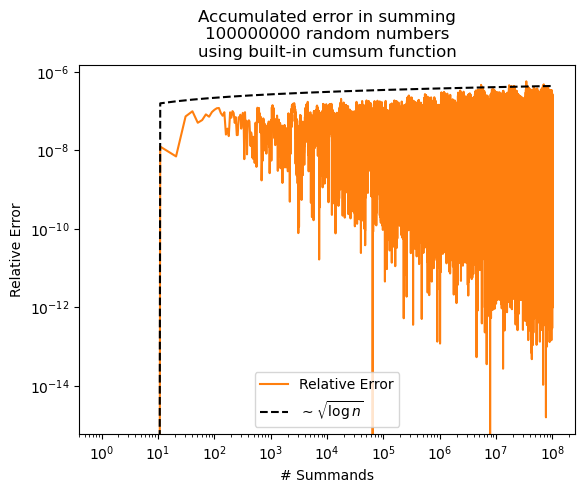

PyObject <matplotlib.legend.Legend object at 0x7f23d49bb450>

In [8]:
function plot_error_analysis_builtin(size_rand_array::Int = 10^8)
    x = rand(Float32, size_rand_array)
    @time y = cumsum(x)
    y_exact = cumsum(Float64.(x))
    err = abs.(y .- y_exact) ./ abs.(y_exact)

    n = 1:10:length(err)
    loglog(n, err[n], color="C1", label="Relative Error")
    ylabel("Relative Error")
    xlabel("# Summands")

    loglog(n, sqrt.(log.(n)) * 1e-7, "k--", label=L"\sim \sqrt{\log{n}}")
    title("Accumulated error in summing" * "\n" * "$size_rand_array random numbers" * "\n" * "using built-in cumsum function")

    legend(loc="best")
end

plot_error_analysis_builtin()

In [9]:
using BenchmarkTools

function sum_accumulated_error(x)
    y = accumulated_error(x)
    return y[end]
end

x_1 = rand(Float32, 10^7)
x_2 = rand(Float64, 10^7)

@btime sum_accumulated_error($x_1)
@btime sum_accumulated_error($x_2)

  6.851 ms (2 allocations: 38.15 MiB)
  10.530 ms (2 allocations: 76.29 MiB)


5.000007435208116e6

In [10]:
using Test

x_1 = rand(Float32, 10^7)
x_2 = rand(Float32, 10^5)
x_3 = rand(Float32, 10^3)

@test sum_accumulated_error(x_1) ≈ sum(x_1)
@test sum_accumulated_error(x_2) ≈ sum(x_2)
@test sum_accumulated_error(x_3) ≈ sum(x_3)

Test Passed